## Lab 4: 5th order and loopshaping
The plant's input-output dynamics are represented by:
$$Y(s)= \frac{R_{of1}+R_{of2}}{R_{of1}}\left[
\left( \frac{R_{om1}}{R_{om1}+R_{om2}}\right)\frac{\omega_{n1}^2}{s^2 + 2\zeta_1 \omega_{n1} s + \omega_{n1}^2} + \left( \frac{R_{om2}}{R_{om1}+R_{om2}}\right)\frac{\omega_{n2}^2}{s^2 + 2\zeta_2 \omega_{n2} s + \omega_{n2}^2}\right]
\left[{\omega\over s+\omega}U(s) + D(s) \right]$$
The system's two inputs are the control input $u$ and the disturbance input $d$. The outputs are the output voltage $y$ and its derivative, $\dot y$. 
The input $u$ to the plant is now filtered with an analog low-pass filter $\omega/(s + \omega)$ that reduces excitation of the high-frequency resonant mode. Design software by S. B. Fuller 2023.04, based on a Matlab version by M. C. Berg 2017.05.

In [206]:
import numpy as np # numerical arrays
import matplotlib.pyplot as plt # plotting
%config InlineBackend.figure_format='retina' # high-res plots
import control.matlab as ctm # matlab layer for control systems library
import control as ct # use regular control library for a few things 
ct.set_defaults('statesp', latex_repr_type='separate') # show ABCD matrices

Natural frequency of low-frequency vibration mode = 0.9825127984059134 Hz
Damping ratio of low-frequency vibration mode = 0.09111805529092465
Natural frequency of high-frequency vibration mode = 20.527664581044217 Hz
Damping ratio of high-frequency vibration mode = 0.05223654379696277


array([[0.91818182, 0.        , 0.09181818, 0.        , 0.        ],
       [0.        , 0.91818182, 0.        , 0.09181818, 0.        ]])

dc gain of state space model = 1.01


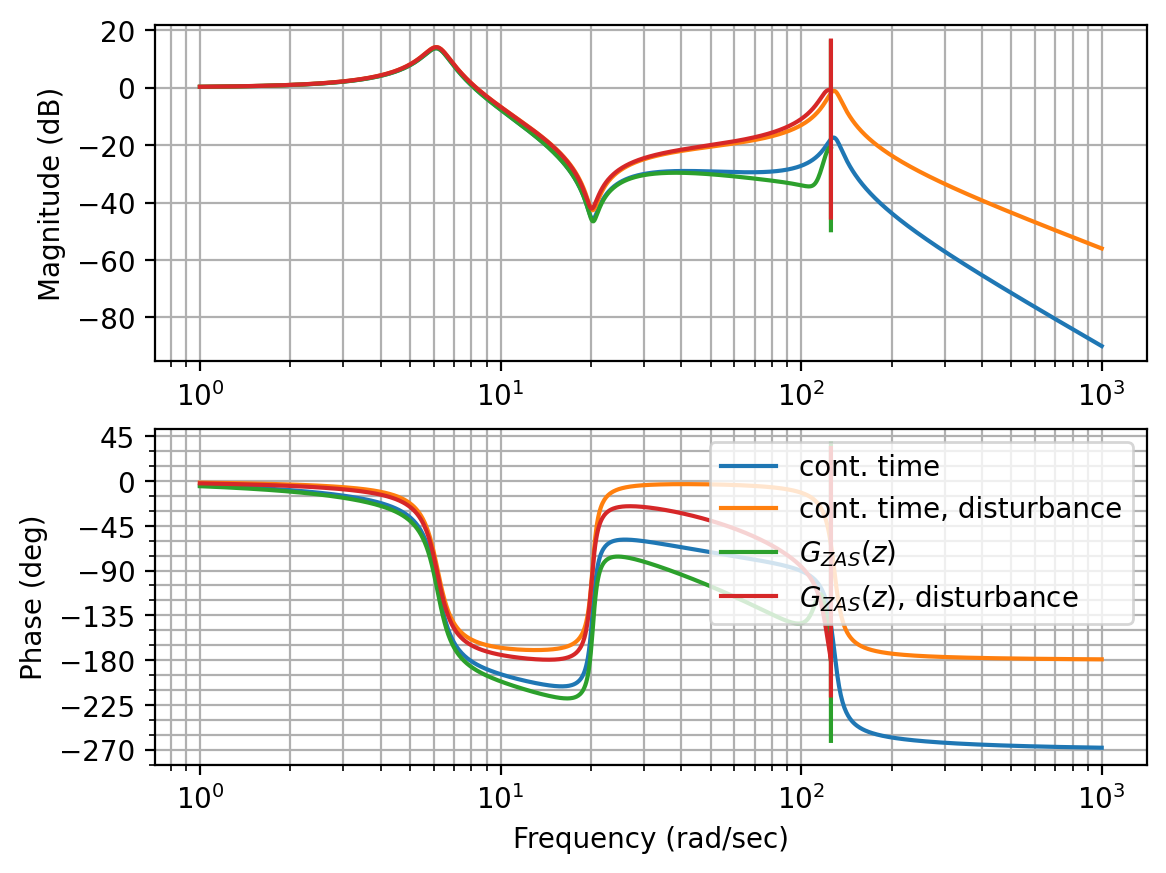

In [207]:
# low-frequency mode
R1 = 160e3 # ohms. "e3" is shorthand for the exponent of ten and means "times 10^3"
R2 = 200e3 # ohms
C1 = 10e-6 # farads
C2 = 0.082e-6 # farads
tau1 = R1 * C1
tau2 = R2 * C2
tau3 = R1 * C2
omegan1 = 1/np.sqrt(tau1 * tau2)
print('Natural frequency of low-frequency vibration mode =', omegan1/(2*np.pi), 'Hz')
zeta1 = (tau2 + tau3) * omegan1/2
print('Damping ratio of low-frequency vibration mode =', zeta1)

# high-frequency mode
R3 = 68e3
R4 = 13e3
C3 = 6.8e-6
C4 = 0.01e-6
tau1 = R3 * C3
tau2 = R4 * C4
tau3 = R3 * C4
omegan2 = 1/np.sqrt(tau1 * tau2);
print('Natural frequency of high-frequency vibration mode =',omegan2/(2*np.pi), 'Hz')
zeta2 = (tau2 + tau3) * omegan2 / 2
print('Damping ratio of high-frequency vibration mode =',zeta2)

# weighting factors
Rof1 = 10e3
Rof2 = 100
Rom1 = 1e3
Rom2 = 10e3 
K1 = (Rof1 + Rof2)/Rof1*Rom2/(Rom1+Rom2) # gain of first mode
K2 = (Rof1 + Rof2)/Rof1*Rom1/(Rom1+Rom2) # gain of second mode

AA = np.array(
    [[          0,                1,            0,                0],  # x1
     [-omegan1**2, -2*zeta1*omegan1,            0,                0],  # d(x1)/dt
     [          0,                0,            0,                1],  # x2
     [          0,                0,  -omegan2**2, -2*zeta2*omegan2]]) # d(x2)/dt
BBu = np.array(
    [[         0], 
     [omegan1**2],
     [         0],            
     [omegan2**2]])
BBd = np.array(
    [[         0], 
     [omegan1**2],
     [         0],            
     [omegan2**2]])
BB = np.hstack([BBu,  BBd])

CC = np.array(
    [[K1,      0,       K2,        0],                  # y    
     [0,       K1,       0,       K2]])                 # dy/dt 
DD = np.array(
    [[0,   0],
     [0,   0]])
plant_nofilter = ctm.ss(AA, BB, CC, DD)

# low-pass filter
Rrolloff = 5e3
Crolloff = 10e-6  
omega_filter = 1/(Rrolloff * Crolloff)
filter_tf = ctm.tf(1, [1/omega_filter, 1])

AA = np.block(
    [[AA,                BB[:,0:1]],    # states: [x1  d(x1)/dt  x2  d(x2)/dt]'
     [np.zeros(4),   -omega_filter]])   # low-pass filter state
BB = np.block(
    [[np.zeros((4, 1)),  BB[:,1:2]],        
     [    omega_filter,          0]])
CC = np.block(
    [CC, np.zeros((2,1))])              # Outputs: [y  dy/dt]' 
DD = np.zeros((2,2))
display(CC)
plant = ctm.ss(AA,BB,CC,DD)
dcgain = ctm.dcgain(plant[0,0])
print('dc gain of state space model =', dcgain)
Kff = 1/dcgain

Ts = .025
plantdisc = ctm.c2d(plant[0,0], Ts, 'zoh')
plantdiscd = ctm.c2d(plant[0,1], Ts, 'zoh')
plantdiscud = ctm.c2d(plant, Ts, 'zoh')
ctm.bode(plant[0,0], label='cont. time')
ctm.bode(plant[0,1], label='cont. time, disturbance')
ctm.bode(plantdisc, label='$G_{ZAS}(z)$')
ctm.bode(plantdiscd, label='$G_{ZAS}(z)$, disturbance')
plt.legend();

## notch filter

TransferFunction(array([ 0.77590284, -1.51229351,  0.75450886]), array([ 1.        , -1.51229351,  0.5304117 ]), 0.025)

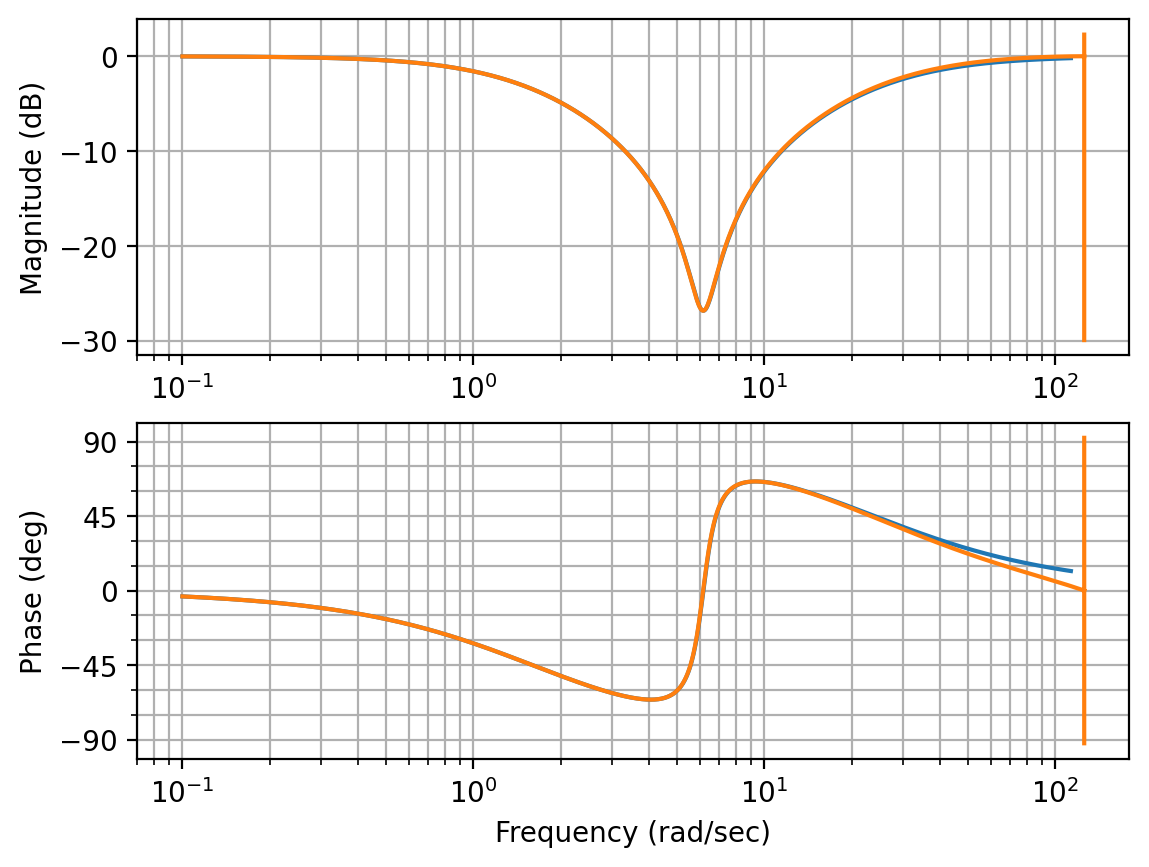

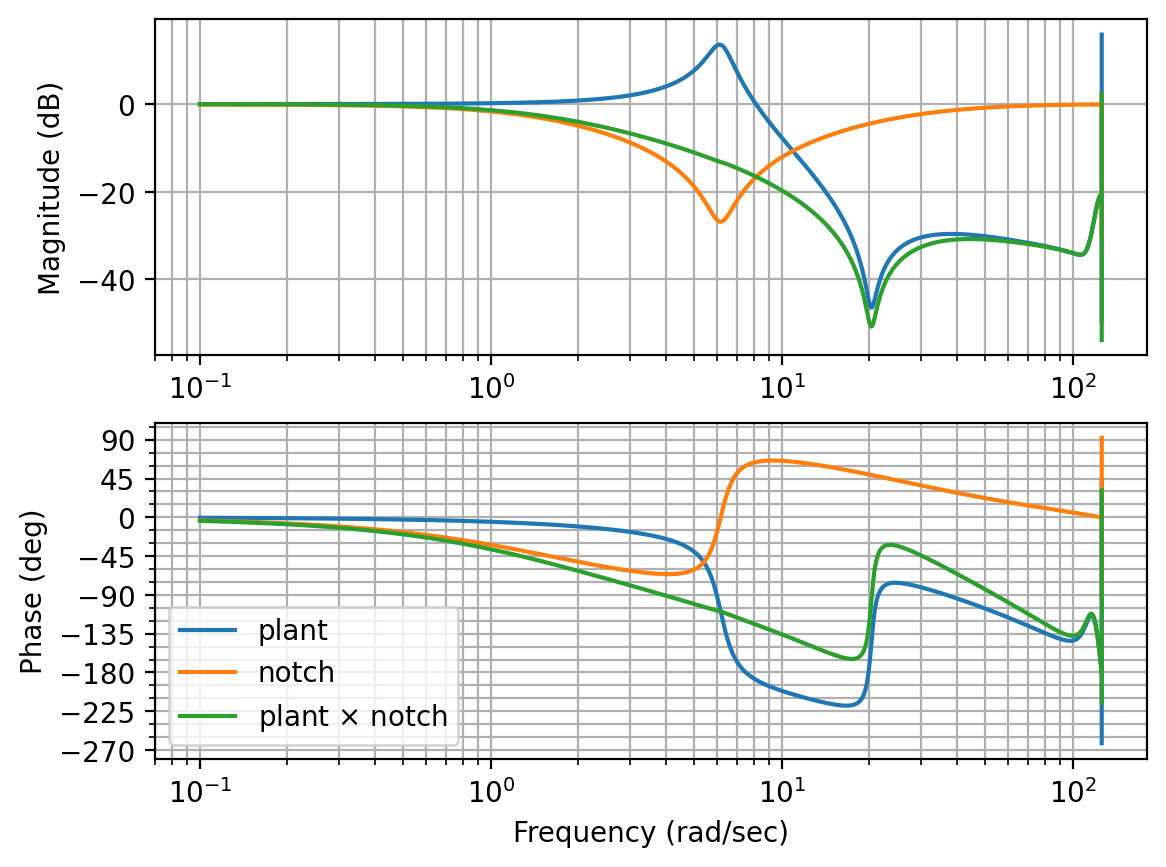

In [208]:
omegan_notch_zeros = 6.1733
zeta_notch_zeros = 0.091118

### to change during design procedure: 
omegan_notch_poles = 6.1733
zeta_notch_poles = 2
###

notch_numerator  = np.array([1,  2*zeta_notch_zeros*omegan_notch_zeros,  omegan_notch_zeros**2])/omegan_notch_zeros**2
notch_denominator =np.array([1,  2*zeta_notch_poles*omegan_notch_poles,  omegan_notch_poles**2])/omegan_notch_poles**2
notch = ctm.tf(notch_numerator, notch_denominator)
notchdisc = ctm.c2d(notch, Ts, 'tustin', prewarp_frequency=omegan_notch_zeros)
display(notchdisc)
ctm.bode((notch, notchdisc))
plt.savefig('notch1.jpg')

plt.figure()
loopdisc1 = plantdisc * notchdisc
loopdisc1ud = plantdiscud * ctm.append(notchdisc, 1) # 2-input version of loopdisc that passes u through notch
ctm.bode((plantdisc, notchdisc, loopdisc1))
plt.legend(('plant', 'notch', r'plant $\times$ notch'));
plt.savefig('notch2.jpg')

## controller/compensator

TransferFunction(array([ 1.002, -0.998]), array([ 1., -1.]), 0.025)

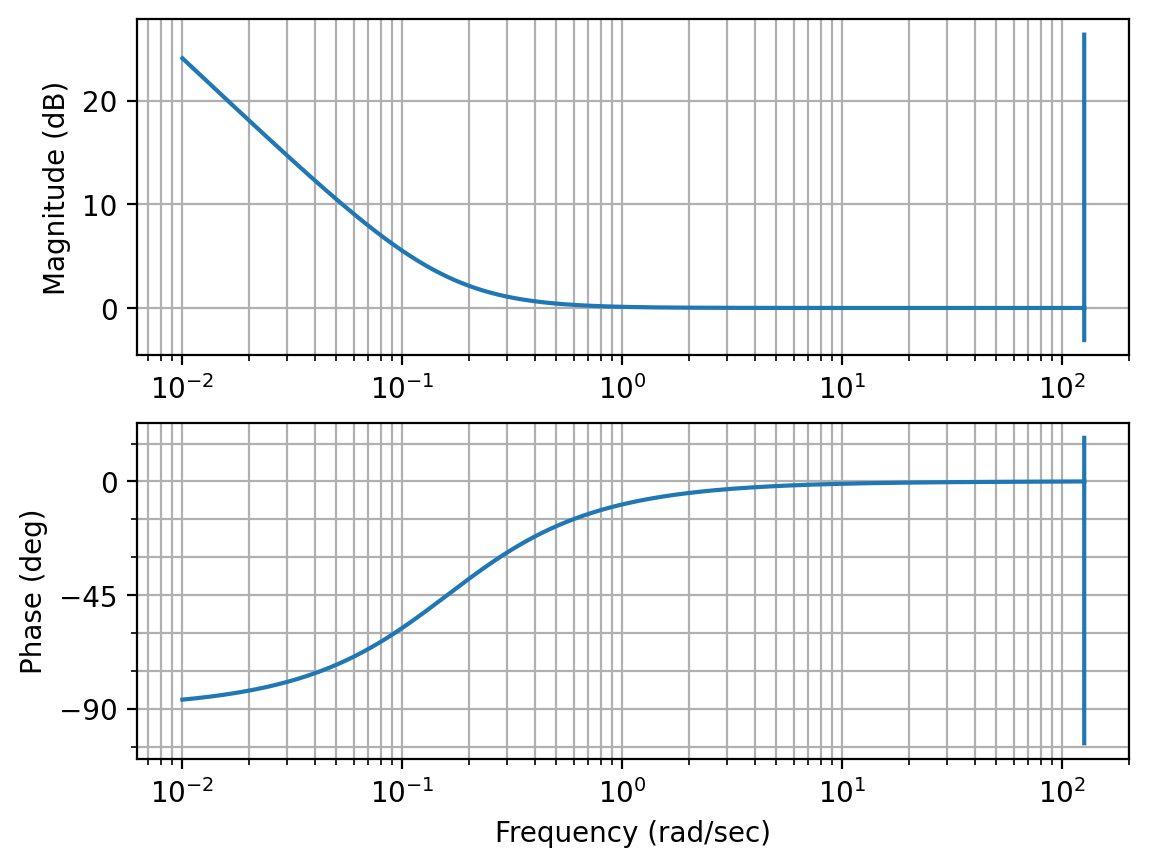

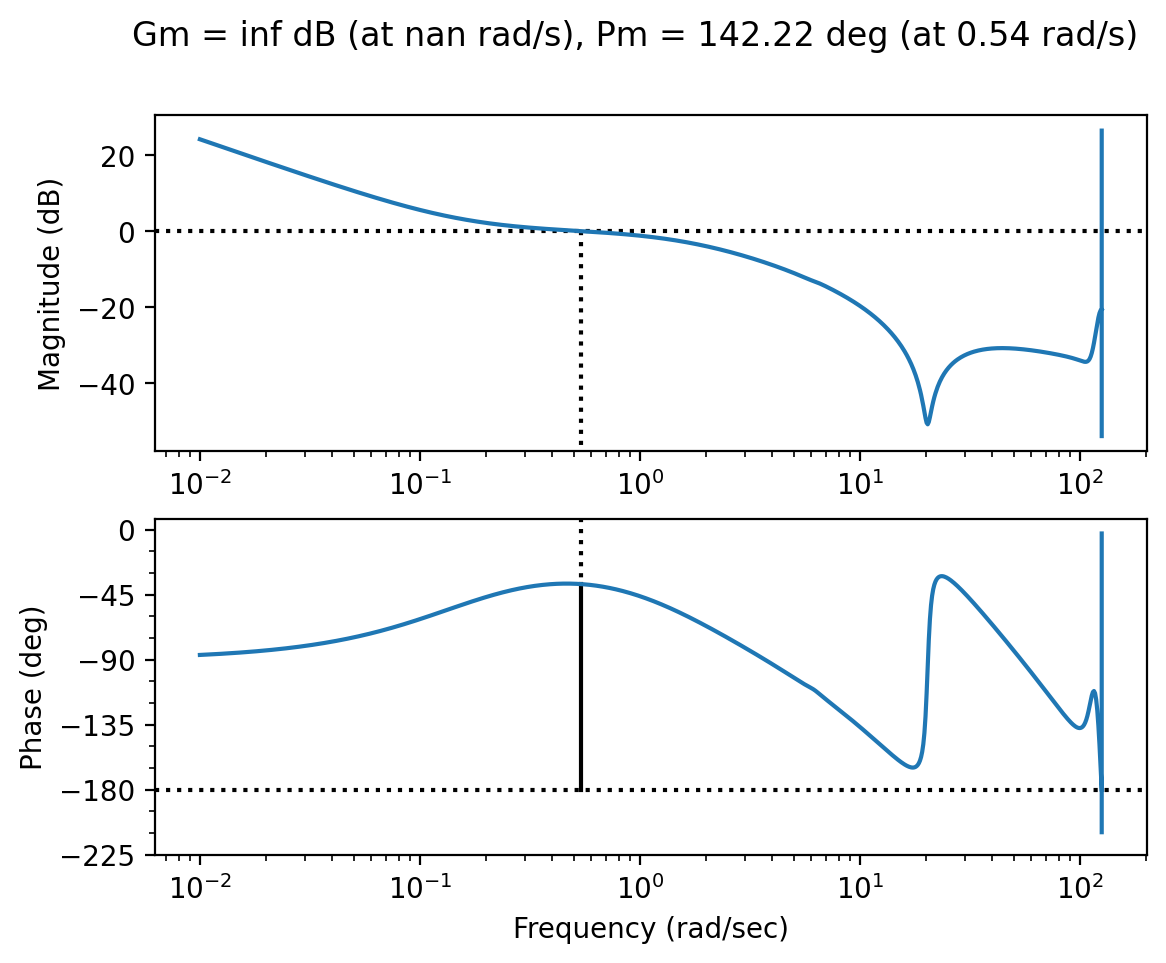

In [209]:
### add code that develops your discrete-time compensator here, or 
# change these coefficients. 
b1 =                  1 #  Numerator's coefficient of z^1
b0 =               0.16 #  Numerator's coefficient of z^0
a1 =                  1 # Denominator's coefficient of z^1
a0 =               0 # Denominator's coefficient of z^0
compensatordisc = ctm.tf([b1,  b0],[a1,  a0]) # compensatordisc is C(z)
compensatordisc = ctm.c2d(compensatordisc, Ts, 'tustin')
###

display(compensatordisc)
ctm.bode(compensatordisc)
plt.savefig('controller1.jpg')
plt.figure()
loopdisc2 = compensatordisc * loopdisc1
ctm.bode(loopdisc2, margins=True, method='frd');
plt.savefig('controller2.jpg')

## plot system response

In [210]:
def sampled_data_controller(controller, plant_dt): 
    """
    Create a (discrete-time, non-linear) system that models the behavior 
    of a digital controller. 
    
    The system that is returned models the behavior of a sampled-data 
    controller, consisting of a sampler and a digital-to-analog converter. 
    The returned system is discrete-time, and its timebase `plant_dt` is 
    much smaller than the sampling interval of the controller, 
    `controller.dt`, to insure that continuous-time dynamics of the plant 
    are accurately simulated. This system must be interconnected
    to a plant with the same dt. The controller's sampling period must be 
    greater than or equal to `plant_dt`, and an integral multiple of it. 
    The plant that is connected to it must be converted to a discrete-time 
    approximation with a sampling interval that is also `plant_dt`. A 
    controller that is a pure gain must have its `dt` specified (not None). 
    """
    assert ct.isdtime(controller, True), "controller must be discrete-time"
    controller = ct.ss(controller) # convert to state-space if not already
    # the following is used to ensure the number before '%' is a bit larger 
    one_plus_eps = 1 + np.finfo(float).eps 
    assert np.isclose(0, controller.dt*one_plus_eps % plant_dt), \
        "plant_dt must be an integral multiple of the controller's dt"
    nsteps = int(round(controller.dt / plant_dt))
    step = 0
    def updatefunction(t, x, u, params): # update if it is time to sample 
        nonlocal step
        if step == 0:
            x = controller._rhs(t, x, u)
        step += 1
        if step == nsteps:
            step = 0
        return x
    y = np.zeros((controller.noutputs, 1))
    def outputfunction(t, x, u, params): # update if it is time to sample
        nonlocal y
        if step == 0: # last time updatefunction was called was a sample time
            y = controller._out(t, x, u) 
        return y
    return ct.NonlinearIOSystem(updatefunction, outputfunction, 
                                dt=plant_dt, 
                                name=controller.name,
                                inputs=controller.input_labels, 
                                outputs=controller.output_labels, 
                                states=controller.state_labels)

c:\Users\YENPANG_HUANG\AppData\Local\Programs\Python\Python311\Lib\site-packages\control\iosys.py:1503: UserWarning: Unused input(s) in InterconnectedSystem: (2, 1)=sys[652].d
  warn(msg)
c:\Users\YENPANG_HUANG\AppData\Local\Programs\Python\Python311\Lib\site-packages\control\iosys.py:1503: UserWarning: Unused input(s) in InterconnectedSystem: (0, 0)=sys[647].r; (3, 0)=sys[651].r
  warn(msg)
c:\Users\YENPANG_HUANG\AppData\Local\Programs\Python\Python311\Lib\site-packages\control\iosys.py:1503: UserWarning: Unused input(s) in InterconnectedSystem: (0, 1)=sys[655]$sampled.d
  warn(msg)
c:\Users\YENPANG_HUANG\AppData\Local\Programs\Python\Python311\Lib\site-packages\control\iosys.py:1503: UserWarning: Unused input(s) in InterconnectedSystem: (2, 0)=sys[647].r; (3, 0)=sys[651].r
  warn(msg)


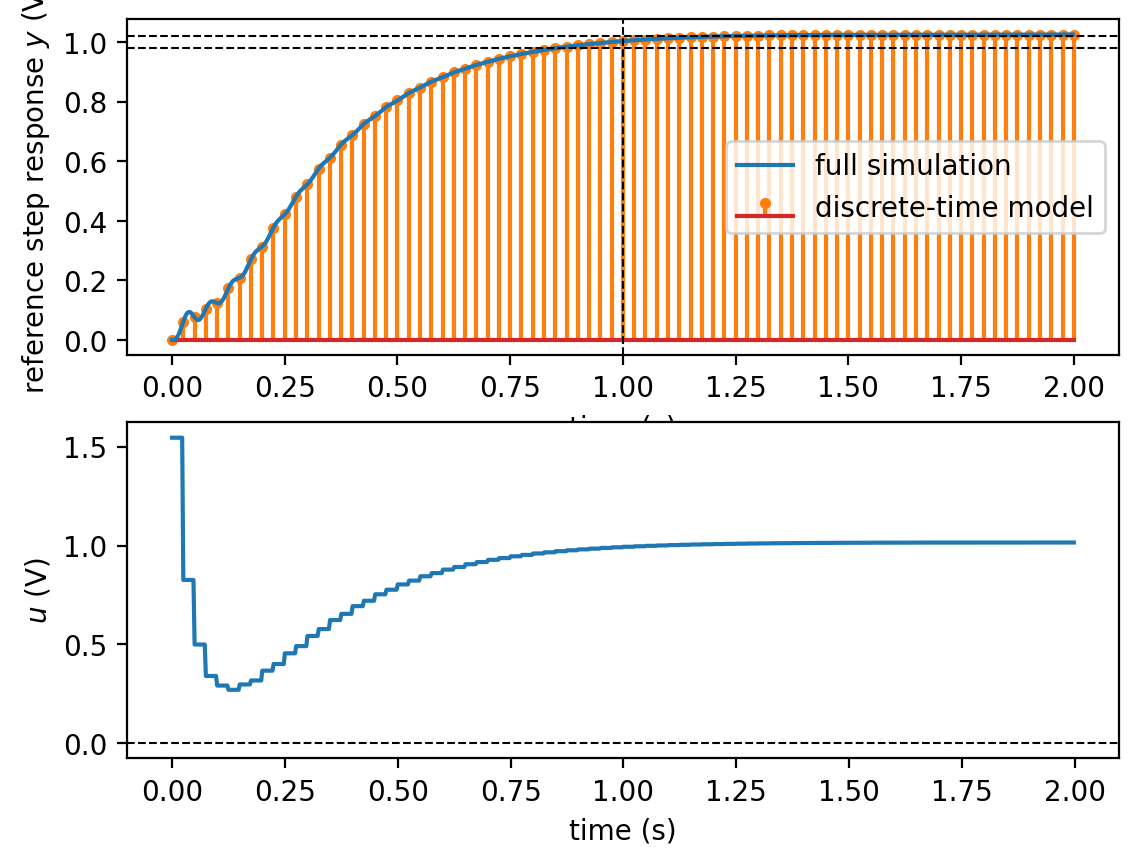

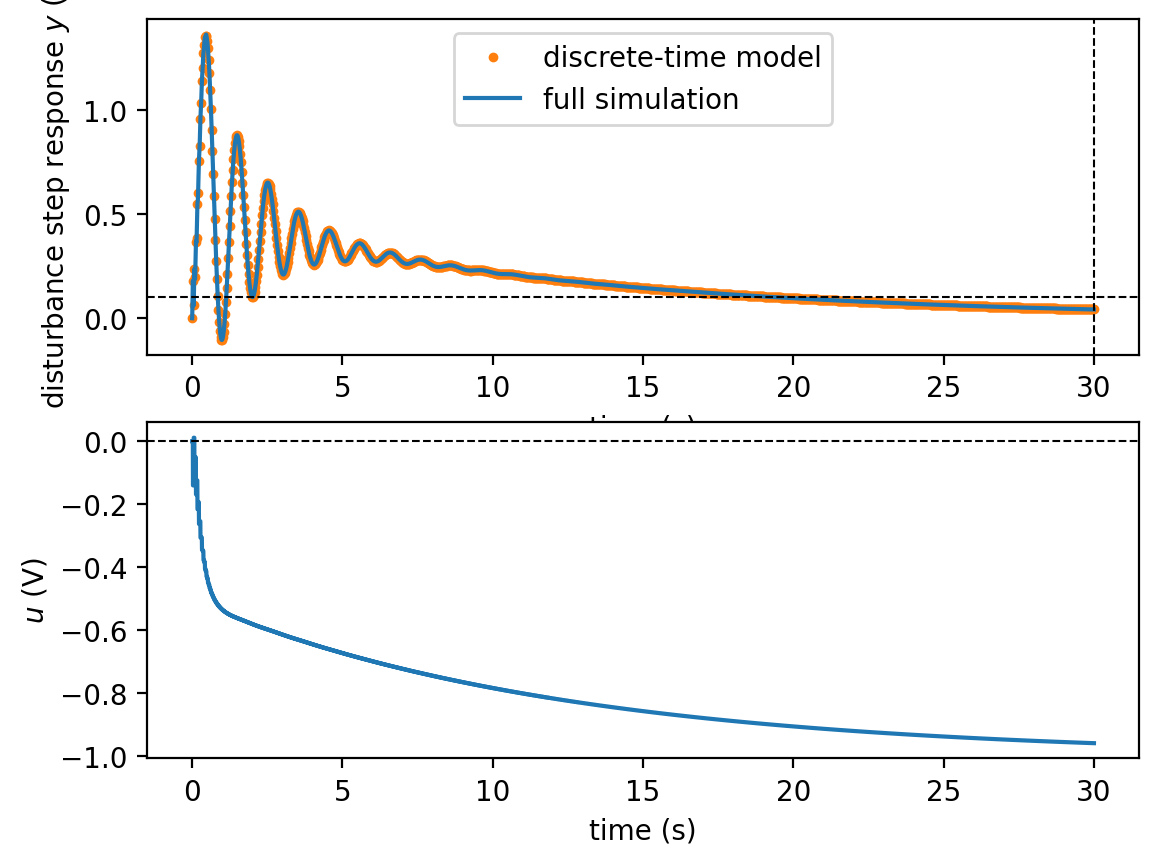

In [211]:
# first simulate discrete-time model from GZAS model of plant, for stem plot
C_ff = ctm.ss(Kff * notchdisc, inputs='r', outputs='uff') 
C_f = ctm.ss(compensatordisc * notchdisc, inputs='e', outputs='uc')
u_summer = ct.summing_junction(['uff', 'uc'], 'u')
e_summer = ct.summing_junction(['r', '-y'], 'e')
Pdisc = ctm.ss(plantdiscud[0,:], inputs=['u', 'd'], outputs='y')
# r to y and d to y
Gyr_discrete = ct.interconnect((C_ff, C_f, Pdisc, e_summer, u_summer), inputs='r', outputs='y')
Gyd_discrete = ct.interconnect((C_ff, C_f, Pdisc, e_summer, u_summer), inputs='d', outputs='y')

# simulate full sampled-data system by simulating with a much shorter dt. 
simulation_dt = 0.0025
C_ff_sim = sampled_data_controller(C_ff, simulation_dt)
C_f_sim = sampled_data_controller(C_f, simulation_dt)
plant_sim = ctm.ss(ctm.c2d(plant[0,:], simulation_dt, 'zoh'), inputs=['u', 'd'], outputs='y')
Gr_sim = ct.interconnect((plant_sim, C_f_sim, C_ff_sim, e_summer, u_summer), 
                             inputs='r', outputs=['y', 'u'])
Gd_sim = ct.interconnect((plant_sim, C_f_sim, C_ff_sim, e_summer, u_summer), 
                             inputs='d', outputs=['y', 'u'])

# step response
plt.figure(1)
plt.subplot(2,1,1)
y, t = ctm.step(Gyr_discrete, T=2)
plt.stem(t, y, 'C1', markerfmt='C1.', label='discrete-time model')

time_sim = np.arange(0, 2, simulation_dt)
input_sim = np.ones_like(time_sim) # step input
t, y  = ct.input_output_response(Gr_sim, time_sim, input_sim) 
plt.plot(t, y[0], label='full simulation')
plt.xlabel('time (s)')
plt.ylabel('reference step response $y$ (V)')
plt.legend()
plt.axhline(1.02, c='k', linestyle="--", linewidth=0.75)
plt.axhline(.98, c='k', linestyle="--", linewidth=0.75)
plt.axvline(1, c='k', linestyle="--", linewidth=0.75)
plt.subplot(2,1,2)
plt.plot(t, y[1])
plt.xlabel('time (s)')
plt.ylabel('$u$ (V)')
plt.axhline(0, c='k', linestyle="--", linewidth=0.75)
plt.savefig('rtoy.jpg')
# disturbance response
plt.figure(2)
plt.subplot(2,1,1)
y, t = ctm.step(Gyd_discrete, T=30)
plt.plot(t, y, 'C1.', markersize=5, label='discrete-time model')

time_sim = np.arange(0, 30, simulation_dt)
input_sim = np.ones_like(time_sim)
t2, y2 = ct.input_output_response(Gd_sim, time_sim, input_sim) 
plt.plot(t2, y2[0], label='full simulation')
plt.xlabel('time (s)')
plt.ylabel('disturbance step response $y$ (V)')
plt.axhline(.1, c='k', linestyle="--", linewidth=0.75)
plt.axvline(30, c='k', linestyle="--", linewidth=0.75)
plt.legend()
plt.subplot(2,1,2)
plt.plot(t2, y2[1])
plt.xlabel('time (s)')
plt.ylabel('$u$ (V)')
plt.axhline(0, c='k', linestyle="--", linewidth=0.75);
plt.savefig('dtoy.jpg')